In [1]:
import sys
import time
import os
import warnings

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

import numpy as np
import fitsio
from astropy.io import fits
import numpy.ma as ma

sys.path.insert(0, '/home/bekah/gphoton_working')
sys.path.insert(0, '/home/bekah/gphoton_working/gPhoton')

from photutils.aperture import CircularAperture
from photutils.utils import make_random_cmap
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse

import pandas as pd 

In [2]:
from pyarrow import parquet

from gPhoton.parquet_utils import parquet_to_ndarray

from astropy.table import Table

from gPhoton.aspect import load_aspect_solution

from gPhoton.io.raw6 import load_raw6

Things I want to do today: 

- test astrometry.net on many different frames of an eclipse, see how similar the answers are 
- figure out all the ways to speed up astrometry.net & implement 
    -> low hanging fruit: code to use known WCS info to narrow down which index files are used 
    -> use source list from my own source extraction? 

In [3]:
def get_image_file(eclipse, band):
    from gPhoton.reference import eclipse_to_paths
    from gPhoton.coadd import zero_flag_and_edge
    # image info
    eclipse, band, depth, compression = eclipse, band, 30, "rice"
    galex_file_paths = eclipse_to_paths(eclipse, '/home/bekah/gphoton_working/test_data', depth,
                                        compression)
    # image to hdul
    hdul = fitsio.FITS(galex_file_paths[band]['image'])
    cnt, flag, edge = [hdu.read() for hdu in hdul[1:4]]
    
    masked_cnt_image = zero_flag_and_edge(cnt, flag, edge)
    return masked_cnt_image

In [4]:
def look_at_hdul(eclipse, band):
    from gPhoton.reference import eclipse_to_paths
    from gPhoton.coadd import zero_flag_and_edge
    # image info
    eclipse, band, depth, compression = eclipse, band, 30, "rice"
    galex_file_paths = eclipse_to_paths(eclipse, '/home/bekah/glcat/astrometry', depth,
                                        compression)
    # image to hdul
    hdul = fitsio.FITS(galex_file_paths[band]['image'])
    
    return hdul 

In [5]:
def centile_clip(image, centiles=(0, 90)):
    """
    simple clipping function that clips values above and below a given
    percentile range
    """
    finite = np.ma.masked_invalid(image)
    bounds = np.percentile(finite[~finite.mask].data, centiles)
    result = np.ma.clip(finite, *bounds)
    
    if isinstance(image, np.ma.MaskedArray):
        
        return result
    
    return result.data

In [6]:
# loading aspect table 
parq  = parquet.read_table('/home/bekah/gphoton_working/gPhoton/aspect/aspect.parquet')
aspect = parq.to_pandas()
#aspect["eclipse"==21442]

In [ ]:
np.mean(aspect[aspect["eclipse"]==21442]["ra"])

In [ ]:
movie = fitsio.FITS("/home/bekah/glcat/astrometry/e23456/e21442-nd-10s-rice.fits")

In [ ]:
len(hdulist[1].data)

In [33]:
my_data = pd.read_csv("/home/bekah/aspect_correction/21442_aspect_soln")

In [34]:
my_data = my_data.transpose()

In [35]:
my_data

,0,1
3,201.062607,27.489099
4,201.062908,27.482276
5,201.064100,27.479973
6,201.073437,27.474539
7,201.080721,27.474916
8,201.083782,27.476461
9,201.090289,27.483311
10,201.091329,27.489097
11,201.088062,27.496937
12,201.081988,27.500119


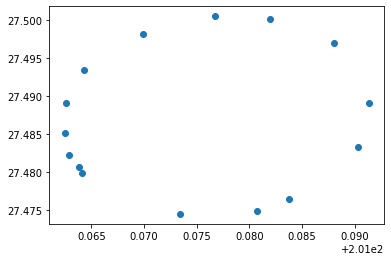

In [36]:
plt.scatter(my_data[0],my_data[1])

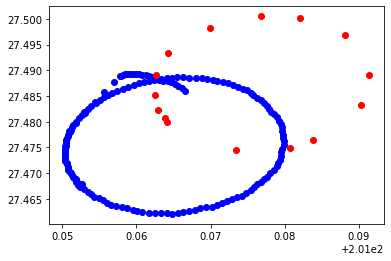

In [37]:
aspect_solution = pd.DataFrame.from_dict(load_aspect_solution(21442))
plt.scatter(aspect_solution['ra'],aspect_solution['dec'],c="blue")
plt.scatter(my_data[0],my_data[1],c="red")

In [ ]:
# code for running on every image in a whole eclipse 
import subprocess
subprocess.call(['sh', './test.sh'])

In [ ]:
from astropy.wcs import WCS
w = WCS('/home/bekah/glcat/astrometry/e23456/e23456-nd-full-rice.wcs')

In [ ]:
# loading eclipse parquet table 
e23456parq  = parquet.read_table("/home/bekah/glcat/astrometry/e23456/e23456-nd.parquet")
e23456parq = e23456parq.to_pandas()
e23456parq

In [ ]:
raw6file = "/home/bekah/glcat/astrometry/e23456/e23456-nd-raw6.fits"
data, nphots = load_raw6(raw6file, 1)

In [ ]:
raw6_data = pd.DataFrame.from_dict(data)

In [ ]:
raw6_data

In [ ]:
hdulist = fits.open("/home/bekah/aspect_correction/frame3.corr")

In [ ]:
hdulist

In [ ]:
from astropy import wcs


w = wcs.WCS(hdulist[0].header)
          # Print out the "name" of the WCS, as defined in the FITS header
          # Print out all of the settings that were parsed from the header
w.wcs.print_contents()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

%matplotlib notebook 

fig, ax = plt.subplots()


# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(14):
    im = ax.imshow(centile_clip(hdulist[1].data[i]*1000), animated=True)
    if i == 0:
        ax.imshow(centile_clip(hdulist[1].data[i]*1000)) # show an initial one first
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

# To save the animation, use e.g.
#
#ani.save("movie.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()

In [ ]:
plt.imshow(centile_clip((hdulist[1].data[3]/10.0),(0,99.5)))

In [ ]:
np.max(hdulist[1].data[3])